This notebook uses more atom and bond features compared to the GNN_1 file.

In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# PyG installation

In [106]:
# install
!pip install torch_geometric

# Optional dependencies:
!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html


# RDKit installation

In [107]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [108]:
condacolab.check()

✨🍰✨ Everything looks OK!


In [109]:
!conda install -c conda-forge rdkit

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



# All requested packages already installed.



# Load modules and data set

In [110]:
import rdkit
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem

import torch
import torch_geometric
from torch_geometric.data import Data

import numpy as np
import pandas as pd
import joblib

In [111]:
pubchem = pd.read_csv("https://www.dropbox.com/s/stxhvcgk0kvs89m/PubchemQC_HOMO-LUMO_100000.csv?dl=1")

In [112]:
pubchem

,#Index,HOMO-LUMO_gap(eV),Oscillator_Strength,SMILES
0,1,4.015,0.002,CC(=O)OC(CC(=O)[O-])C[N+](C)(C)C
1,2,5.758,0.000,CC(=O)OC(CC(=O)O)C[N+](C)(C)C
2,3,4.039,0.053,C1=CC(C(C(=C1)C(=O)O)O)O
3,4,5.596,0.004,CC(CN)O
4,5,4.278,0.001,C(C(=O)COP(=O)(O)O)N
...,...,...,...,...
99994,303049,4.282,0.092,COC(C1=CC=CC2=CC=CC=C21)C(=O)O
99995,303051,5.805,0.005,CCS(=O)(=O)N1CCCCC1C
99996,303052,5.891,0.019,CCN(CC)S(=O)(=O)CC
99997,303053,5.876,0.006,CCCN(CCC)S(=O)(=O)CC


We will use the molecules consisting of H, B, C, N, O, F, P, S, and Cl ony.

In [113]:
# check the molecules that meet the requirement for atomic compositions
def check_atoms(mol):
  """
  This function checks whether all atoms are valid
  """
  valid_atoms = ('H', 'B', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl')
  flag = True
  for atm in mol.GetAtoms():       # for loop: atoms in the molecules
    if atm.GetSymbol() not in valid_atoms:
      flag = False
      break
  return flag

In [114]:
from tqdm import tqdm
homo_lumo_data = []
for smi, score in tqdm(zip(pubchem['SMILES'], pubchem['HOMO-LUMO_gap(eV)'])):
  mol = Chem.MolFromSmiles(smi)
  if check_atoms(mol):
    homo_lumo_data.append((Chem.MolFromSmiles(smi), score))
  else:
    continue

569it [00:04, 380.61it/s][09:06:10] WARNING: not removing hydrogen atom without neighbors
[09:06:10] WARNING: not removing hydrogen atom without neighbors
16168it [00:18, 1513.93it/s][09:06:23] WARNING: not removing hydrogen atom without neighbors
[09:06:23] WARNING: not removing hydrogen atom without neighbors
41717it [00:26, 3099.92it/s][09:06:32] WARNING: not removing hydrogen atom without neighbors
[09:06:32] WARNING: not removing hydrogen atom without neighbors
99999it [00:53, 1884.10it/s]


# Graph representation of molecules

In [115]:
def convert_mol_to_graph(mol, use_pos = False):

  mol2 = Chem.AddHs(mol)                      # add hydrogens
  n_bonds = len(mol2.GetBonds())              # the number of covalent bonds
  n_atoms = len(mol2.GetAtoms())              # the number of atoms

  ## calculate the edge attributes and weights
  edge_index = []
  edge_attr = []
  edge_weight = []

  for idx in range(n_bonds):                  # 'for loop' for entire bonds
    bond = mol2.GetBondWithIdx(idx)           # get a bond index for each bond
    edge_index.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])   # save a list of begin and end atom indices for each covalent bond
    edge_index.append([bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()])   # the opposite direction as it's undirected graphs

    # bond type (4-dimensional one-hot)
    btype = bond.GetBondType()                # types of bonds
    if btype == Chem.rdchem.BondType.SINGLE:  # single bond
      bond_one_hot = [1, 0, 0, 0]             # for edge_attr: one-hot encoding for bond types
      edge_weight.extend([1.0, 1.0])          # for edge_weight: 1 for single bonds
    elif btype == Chem.rdchem.BondType.AROMATIC:    # aromatic bond
      bond_one_hot = [0, 1, 0, 0]
      edge_weight.extend([1.5, 1.5])
    elif btype == Chem.rdchem.BondType.DOUBLE:      # double bond
      bond_one_hot = [0, 0, 1, 0]
      edge_weight.extend([2.0, 2.0])
    elif btype == Chem.rdchem.BondType.TRIPLE:      # triple bond
      bond_one_hot = [0, 0, 0, 1]
      edge_weight.extend([3.0, 3.0])

    # bond stereo (6-dimensional one-hot)
    stype = bond.GetStereo()
    if stype == Chem.rdchem.BondStereo.STEREOANY:
      stereo_one_hot = [1, 0, 0, 0, 0, 0]
    elif stype == Chem.rdchem.BondStereo.STEREOCIS:
      stereo_one_hot = [0, 1, 0, 0, 0, 0]
    elif stype == Chem.rdchem.BondStereo.STEREOE:
      stereo_one_hot = [0, 0, 1, 0, 0, 0]
    elif stype == Chem.rdchem.BondStereo.STEREONONE:
      stereo_one_hot = [0, 0, 0, 1, 0, 0]
    elif stype == Chem.rdchem.BondStereo.STEREOTRANS:
      stereo_one_hot = [0, 0, 0, 0, 1, 0]
    elif stype == Chem.rdchem.BondStereo.STEREOZ:
      stereo_one_hot = [0, 0, 0, 0, 0, 1]

    # does this bond include a ring?
    if bond.IsInRing():
      ring_bond = 1
    else:
      ring_bond = 0

    # is this bond a conjugates bond?
    if bond.GetIsConjugated():
      conjugate = 1
    else:
      conjugate = 0

    # total 12-dimensional edge attributes
    # bond-type (4-dim), bondstereo (6-dim), ring? (1-dim), conjugate? (1-dim)
    attr = bond_one_hot + stereo_one_hot + [ring_bond, conjugate]

    edge_attr.append(attr)
    edge_attr.append(attr)      # append two times as it's an undirected graph
  ## complete the edge attributes and weights


  ## calculate the node features
  # refer to this link, https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html#rdkit.Chem.rdchem.Atom
  #        0.   1.   2.   3.   4.   5.   6.   7.   8.
  #       'H', 'B', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl'
  valid_atoms = {'H':0, 'B':1, 'C':2, 'N':3, 'O':4, 'F':5, 'P':6, 'S':7, 'Cl':8}
  node_attr = []

  for atm_id in range(n_atoms):
    # select an atom
    atm = mol2.GetAtomWithIdx(atm_id)

    # atom symbol check (9-dim)
    sym = atm.GetSymbol()
    atm_one_hot = [0] * len(valid_atoms)  # make a list consisting of nine zeros
    idx = valid_atoms[sym]                # check what the element is
    atm_one_hot[idx] = 1                  # change to one from zero for the element

    # check hybridization (7-dim)
    hybrid = atm.GetHybridization()
    hybrid_one_hot = [0] * 7              # make a list consisting of nine zeros
    if hybrid == Chem.HybridizationType.SP3:
      hybrid_one_hot[0] == 1
    elif hybrid == Chem.HybridizationType.SP2:
      hybrid_one_hot[1] = 1
    elif hybrid == Chem.HybridizationType.SP:
      hybrid_one_hot[2] = 1
    elif hybrid == Chem.HybridizationType.S:
      hybrid_one_hot[3] = 1
    elif hybrid == Chem.HybridizationType.SP3D:
      hybrid_one_hot[4] = 1
    elif hybrid == Chem.HybridizationType.SP3D2:
      hybrid_one_hot[5] = 1
    else: # all other cases
      hybrid_one_hot[6] = 1

    # check aromaticity: 0 or 1
    if atm.GetIsAromatic():
      arom = 1
    else:
      arom = 0

    # ring?
    if atm.IsInRing():
      ring_flag = 1
    else:
      ring_flag = 0

    # degree (the number of covalent bonds) (6-dimensional one-hot)
    # 0, 1, 2, 3, 4, >=5
    degree_one_hot = [0] * 6
    degree = atm.GetTotalDegree()
    if degree >= 5:
      degree_one_hot[5] = 1
    else:
      degree_one_hot[degree] = 1

    # the number of hydrogen bonded (5-dim, one-hot)
    # 0, 1, 2, 3, >=4
    num_h = atm.GetTotalNumHs()
    hydrogen_one_hot = [0] * 5
    if num_h >= 4:
      hydrogen_one_hot[4] = 1
    else:
      hydrogen_one_hot[num_h] = 1

    # chirality (4-dimensional one-hot)
    chiral = atm.GetChiralTag()
    if chiral == Chem.rdchem.ChiralType.CHI_OTHER:
      chiral_one_hot = [1, 0, 0, 0]
    elif chiral == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW:    # couter-clockwise
      chiral_one_hot = [0, 1, 0, 0]
    elif chiral == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW:     # clockwise
      chiral_one_hot = [0, 0, 1, 0]
    elif chiral == Chem.rdchem.ChiralType.CHI_UNSPECIFIED:        # chirality not defined
      chiral_one_hot = [0, 0, 0, 1]

    # atomic feature calculation;
    # [atomic symbol one-hot, hybridization, aromaticity, ring, degree, # of hydrogen, chirality, formal charge, # of radical electrons]
    # 9 + 7 + 1 + 1 + 6 + 5 + 4 + 1 + 1 = 35 dimensions
    attr = atm_one_hot + hybrid_one_hot + degree_one_hot + hydrogen_one_hot + \
           chiral_one_hot + [arom, ring_flag, atm.GetFormalCharge(), atm.GetNumRadicalElectrons()]

    node_attr.append(attr)
  ## complete the node features

  # change the types of all node and edge features to pytorch tensors
  edge_attr = torch.tensor(edge_attr, dtype = torch.float)
  node_attr = torch.tensor(node_attr, dtype = torch.float)
  edge_index = torch.tensor(edge_index, dtype = torch.long)       # (2 * # of covalent bonds x 2)
  edge_index = edge_index.t().contiguous()                        # 2 x (2 * # of covalent bonds), shape change required for PyG operations
  edge_weight = torch.tensor(edge_weight, dtype = torch.float)    # one dimensional tensor (2 * # of bonds)

  if use_pos:               # if coordinates(=positional) information used
    val = AllChem.EmbedMolecule(mol2)     # EmbedMolecule: method for predicting the 3d structures of molecules
    if val != 0:
      print(f"Error while generating 3D: {Chem.MolToSmiles(mol)}")
      return None

    pos_list = []           # this is optional
    for atm_id in range(n_atoms):
      # get atomic positions
      atm_pos = mol2.GetConformer(0).GetAtomPosition(atm_id)
      crd = [atm_pos.x, atm_pos.y, atm_pos.z]
      pos_list.append(crd)

    pos = torch.tensor(pos_list, dtype = torch.float)
  else:
    pos = None

  return edge_index, node_attr, edge_attr, pos, edge_weight

In [116]:
edge_index, x, edge_attr, pos, edge_weight = convert_mol_to_graph(homo_lumo_data[0][0])

In [117]:
d0 = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, pos=pos, edge_weight=edge_weight)

In [118]:
print(d0)

Data(x=[31, 35], edge_index=[2, 60], edge_attr=[60, 12], edge_weight=[60])


In [119]:
d0.num_nodes, d0.num_edges, d0.edge_weight

(31,
 60,
 tensor([1., 1., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1.]))

# Transformation into PyG data type

In [120]:
data_list = []
for mol, score in tqdm(homo_lumo_data):
  result = convert_mol_to_graph(mol)
  if result is None:
    continue

  edge_index, node_attr, edge_attr, pos, edge_weight = result
  y = torch.tensor([[score]], dtype=torch.float)
  dtmp = Data(x = node_attr, pos = pos, edge_index = edge_index, edge_attr = edge_attr, edge_weight = edge_weight, y = y)
  data_list.append(dtmp)

100%|██████████| 99999/99999 [01:31<00:00, 1090.33it/s]


In [121]:
from torch_geometric.loader import DataLoader

In [122]:
import random
random.seed(12345)
random.shuffle(data_list)

In [123]:
# train/validation/test split
train_set, val_set, test_set = data_list[:-20000], data_list[-20000:-15000], data_list[-15000:]
print(len(train_set))
print(len(val_set))
print(len(test_set))

79999
5000
15000


In [124]:
# import to data loader
train_loader = DataLoader(train_set, batch_size=100, shuffle=True, drop_last=False)
val_loader = DataLoader(val_set, batch_size=100, shuffle=False, drop_last=False)
test_loader = DataLoader(test_set, batch_size=100, shuffle=True, drop_last=False)

In [125]:
print(train_loader)

In [126]:
print(len(train_loader.dataset))
print(len(val_loader.dataset))
print(len(test_loader.dataset))

79999
5000
15000


# Define graph convolutional network model

Compared to the GNN_1 file, more number of channels and less number of layers will be used.

In [127]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class myGCN(torch.nn.Module):
  def __init__(self, in_channel=35, hidden_layer_size=70):
    super().__init__()
    self.conv1 = GCNConv(in_channel, hidden_layer_size)         # a basic graph convolutional model, https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
    self.conv2 = GCNConv(hidden_layer_size, hidden_layer_size)
    self.conv3 = GCNConv(hidden_layer_size, hidden_layer_size)
    # self.conv4 = GCNConv(hidden_layer_size, hidden_layer_size)
    # self.conv5 = GCNConv(hidden_layer_size, hidden_layer_size)
    self.lin1 = Linear(hidden_layer_size, int(hidden_layer_size/2))
    self.lin2 = Linear(int(hidden_layer_size/2), 1)

  def forward(self, data):
    x, edge_index, batch, edge_weight = data.x, data.edge_index, data.batch, data.edge_weight

    x = self.conv1(x, edge_index)
    x = F.gelu(x)
    x = F.dropout(x, training=self.training)

    x = self.conv2(x, edge_index)
    x = F.gelu(x)

    x = self.conv3(x, edge_index)
    x = F.gelu(x)

    # x = self.conv4(x, edge_index)
    # x = F.elu(x)

    # x = self.conv5(x, edge_index)
    # x = F.elu(x)

    # READOUT
    x = global_mean_pool(x, batch)      # take the mean of node features, [batch_size, hidden_channels]
    x = self.lin1(x)
    x = F.elu(x)
    x = self.lin2(x)                    # final scalar

    return x

In [128]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [129]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

# print model
model = myGCN(in_channel=35, hidden_layer_size=70)
model.to(device)

cuda


myGCN(
  (conv1): GCNConv(35, 70)
  (conv2): GCNConv(70, 70)
  (conv3): GCNConv(70, 70)
  (lin1): Linear(in_features=70, out_features=35, bias=True)
  (lin2): Linear(in_features=35, out_features=1, bias=True)
)

In [130]:
count_parameters(model)

+------------------+------------+
|     Modules      | Parameters |
+------------------+------------+
|    conv1.bias    |     70     |
| conv1.lin.weight |    2450    |
|    conv2.bias    |     70     |
| conv2.lin.weight |    4900    |
|    conv3.bias    |     70     |
| conv3.lin.weight |    4900    |
|   lin1.weight    |    2450    |
|    lin1.bias     |     35     |
|   lin2.weight    |     35     |
|    lin2.bias     |     1      |
+------------------+------------+
Total Trainable Params: 14981


14981

In [131]:
# optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()

In [132]:
import sys

In [133]:
def train(loader):
  model.train()
  for idx, batch in enumerate(loader):
    out = model(batch.to(device))
    loss = criterion(out, batch.y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if idx%100 == 0:
      print(f"IDX: {idx:5d}\tLoss: {loss:.4f}")

In [134]:
def test(loader):
  model.eval()
  error = 0.0
  out_all = []
  true = []
  for data in loader:     # iterate in batches over the training/test dataset
    out = model(data.to(device))
    tmp = (out - data.y)**2
    error += tmp.sum().item()     # check against ground-truch labels

    out_all.extend([x.item() for x in out])
    true.extend([x.item() for x in data.y])

  return error / len(loader.dataset), out_all, true

In [135]:
# model training
train_acc_list = []
val_acc_list = []
test_acc_list = []
for epoch in range(1, 20):
  print("="*100)
  print("Epoch: ", epoch)

  train(train_loader)

  train_acc, out_tmp, true_tmp = test(train_loader)
  train_acc_list.append(train_acc)

  test_acc, out_all, true_all = test(test_loader)
  test_acc_list.append(test_acc)

  val_acc, val_pred, val_true = test(val_loader)
  val_acc_list.append(val_acc)

  print("-"*100)
  print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch:  1
IDX:     0	Loss: 19.5592
IDX:   100	Loss: 0.7958
IDX:   200	Loss: 0.7213
IDX:   300	Loss: 0.5229
IDX:   400	Loss: 0.6350
IDX:   500	Loss: 0.8427
IDX:   600	Loss: 0.4262
IDX:   700	Loss: 0.7196
----------------------------------------------------------------------------------------------------
Epoch: 001, Train Acc: 0.4801, Val Acc: 0.4970, Test Acc: 0.4889
Epoch:  2
IDX:     0	Loss: 0.4932
IDX:   100	Loss: 0.4122
IDX:   200	Loss: 0.3699
IDX:   300	Loss: 0.4862
IDX:   400	Loss: 0.5395
IDX:   500	Loss: 0.4381
IDX:   600	Loss: 0.5073
IDX:   700	Loss: 0.5069
----------------------------------------------------------------------------------------------------
Epoch: 002, Train Acc: 0.3570, Val Acc: 0.3585, Test Acc: 0.3705
Epoch:  3
IDX:     0	Loss: 0.3525
IDX:   100	Loss: 0.2843
IDX:   200	Loss: 0.2921
IDX:   300	Loss: 0.4258
IDX:   400	Loss: 0.3061
IDX:   500	Loss: 0.2194
IDX:   600	Loss: 0.2717
IDX:   700	Loss: 0.3734
-------------------------------------------------------------

# Plotting results

In [136]:
import matplotlib.pyplot as plt

def draw_loss_change(train_loss, val_loss, test_loss):
  plt.figure(figsize=(8,8))
  plt.plot(train_loss, color = 'r', label = 'Train loss')
  plt.plot(val_loss, color = 'b', label = 'Val loss')
  plt.plot(test_loss, color = 'g', label = 'Test loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc='best')

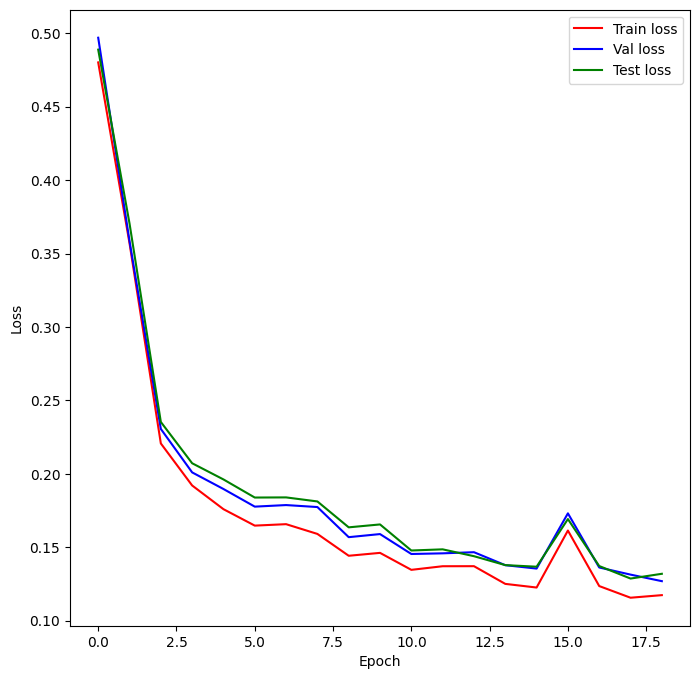

In [137]:
draw_loss_change(train_acc_list, val_acc_list, test_acc_list)

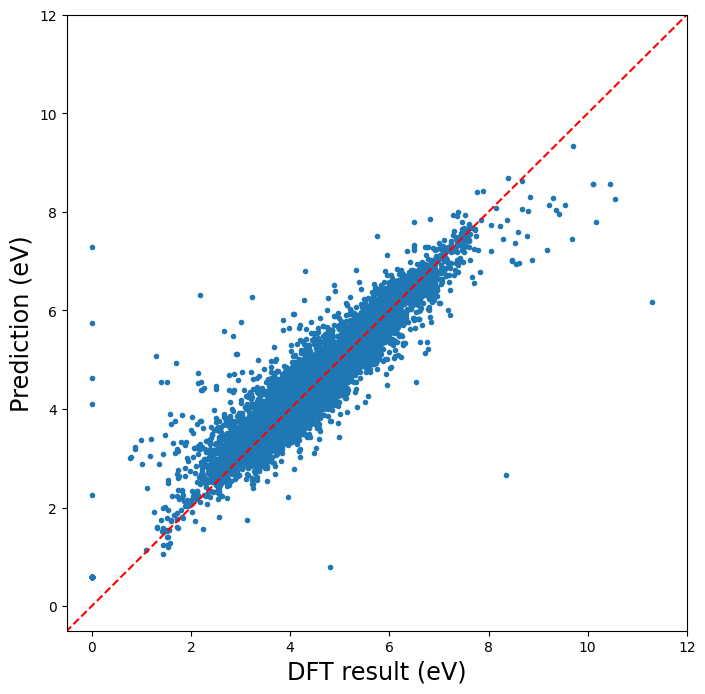

In [138]:
# parity plot
#out_all = [x.detach().numpy() for x in out_all]
dft = [x for x in true_all]
prediction = [x for x in out_all]

plt.figure(figsize=(8, 8))
plt.scatter(dft, prediction, marker = '.')
plt.plot(range(-1, 16), range(-1, 16), 'r--')
plt.xlabel("DFT result (eV)", fontsize='xx-large')
plt.ylabel("Prediction (eV)", fontsize='xx-large')
plt.xlim(-0.5, 12)
plt.ylim(-0.5, 12);

In [139]:
corr = np.corrcoef(dft, prediction)
print(corr)

[[1.         0.93375501]
 [0.93375501 1.        ]]


In [140]:
print(f"Pearson R: {corr[0,1]:.4f}")

Pearson R: 0.9338


# GCNConv with edge weight information

In [141]:
# model using edge weight
class myGCN2(torch.nn.Module):
  def __init__(self, in_channel=35, hidden_layer_size=70):
    super().__init__()
    self.conv1 = GCNConv(in_channel, hidden_layer_size)         # a basic graph convolutional model, https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
    self.conv2 = GCNConv(hidden_layer_size, hidden_layer_size)
    self.conv3 = GCNConv(hidden_layer_size, hidden_layer_size)
    # self.conv4 = GCNConv(hidden_layer_size, hidden_layer_size)
    # self.conv5 = GCNConv(hidden_layer_size, hidden_layer_size)
    self.lin1 = Linear(hidden_layer_size, int(hidden_layer_size/2))
    self.lin2 = Linear(int(hidden_layer_size/2), 1)

  def forward(self, data):
    x, edge_index, batch, edge_weight = data.x, data.edge_index, data.batch, data.edge_weight

    x = self.conv1(x, edge_index, edge_weight)
    x = F.gelu(x)
    x = F.dropout(x, training=self.training)

    x = self.conv2(x, edge_index, edge_weight)
    x = F.gelu(x)

    x = self.conv3(x, edge_index, edge_weight)
    x = F.gelu(x)

    # x = self.conv4(x, edge_index)
    # x = F.elu(x)

    # x = self.conv5(x, edge_index)
    # x = F.elu(x)

    # READOUT
    x = global_mean_pool(x, batch)      # take the mean of node features, [batch_size, hidden_channels]
    x = self.lin1(x)
    x = F.elu(x)
    x = self.lin2(x)                    # final scalar

    return x

In [142]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)
model = myGCN2(in_channel=35, hidden_layer_size=70)
model.to(device)

cuda


myGCN2(
  (conv1): GCNConv(35, 70)
  (conv2): GCNConv(70, 70)
  (conv3): GCNConv(70, 70)
  (lin1): Linear(in_features=70, out_features=35, bias=True)
  (lin2): Linear(in_features=35, out_features=1, bias=True)
)

In [143]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()

In [144]:
for epoch in range(1, 20):
    print("="*100)
    print("Epoch: ", epoch)
    train(train_loader)
    train_acc, out_tmp, true_tmp = test(train_loader)
    test_acc, out_all, true_all = test(test_loader)
    val_acc, val_pred, val_true = test(val_loader)
    print("-"*100)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch:  1
IDX:     0	Loss: 22.4729
IDX:   100	Loss: 0.7270
IDX:   200	Loss: 1.2277
IDX:   300	Loss: 0.4522
IDX:   400	Loss: 0.6703
IDX:   500	Loss: 0.5376
IDX:   600	Loss: 0.5998
IDX:   700	Loss: 0.5910
----------------------------------------------------------------------------------------------------
Epoch: 001, Train Acc: 0.5074, Val Acc: 0.5134, Test Acc: 0.5144
Epoch:  2
IDX:     0	Loss: 0.5466
IDX:   100	Loss: 0.3685
IDX:   200	Loss: 0.3765
IDX:   300	Loss: 0.3259
IDX:   400	Loss: 0.3305
IDX:   500	Loss: 0.4017
IDX:   600	Loss: 0.3037
IDX:   700	Loss: 0.2738
----------------------------------------------------------------------------------------------------
Epoch: 002, Train Acc: 0.2683, Val Acc: 0.2805, Test Acc: 0.2851
Epoch:  3
IDX:     0	Loss: 0.2422
IDX:   100	Loss: 0.4368
IDX:   200	Loss: 0.2244
IDX:   300	Loss: 0.2761
IDX:   400	Loss: 0.1844
IDX:   500	Loss: 0.2161
IDX:   600	Loss: 0.2959
IDX:   700	Loss: 0.1421
-------------------------------------------------------------

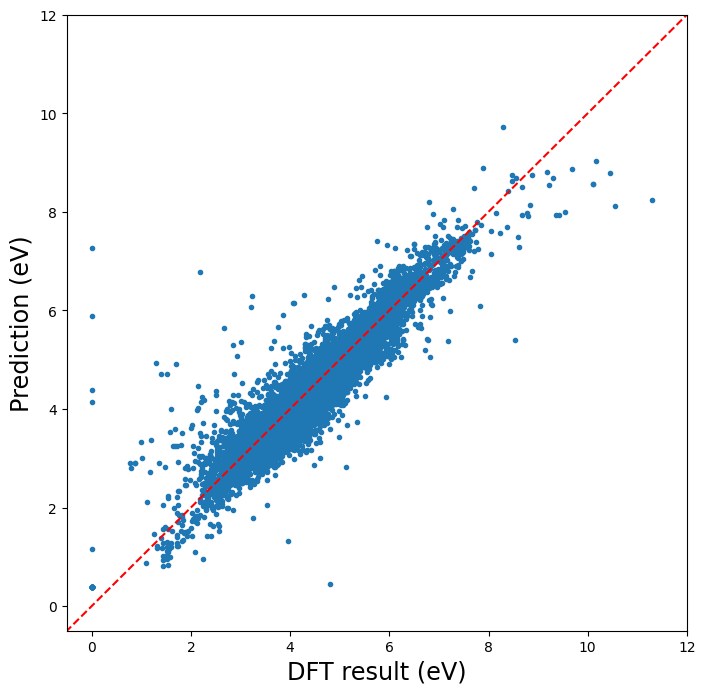

In [145]:
# parity plot
dft = [x for x in true_all]
prediction = [x for x in out_all]

plt.figure(figsize=(8, 8))
plt.scatter(dft, prediction, marker = '.')
plt.plot(range(-1, 16), range(-1, 16), 'r--')
plt.xlabel("DFT result (eV)", fontsize='xx-large')
plt.ylabel("Prediction (eV)", fontsize='xx-large')
plt.xlim(-0.5, 12)
plt.ylim(-0.5, 12);

In [146]:
corr = np.corrcoef(dft, prediction)
r = corr[0,1]
print(f"Pearson R: {r:.4f}")

Pearson R: 0.9314


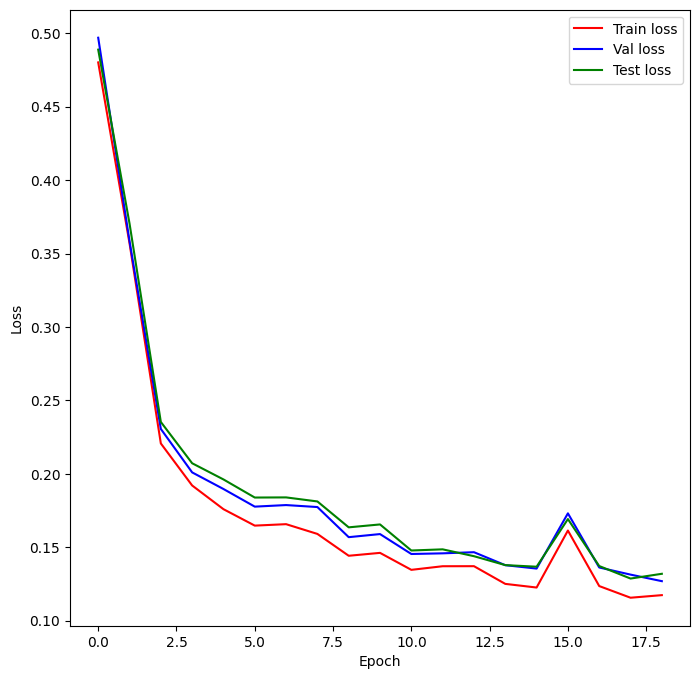

In [147]:
draw_loss_change(train_acc_list, val_acc_list, test_acc_list)

# Graph Attentive Network

## GATConv model (Using node features and edge indices)

In [148]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool

class myGAT(torch.nn.Module):
  def __init__(self, in_channel=35, hidden_layer_size=70):
    super().__init__()
    self.conv1 = GATConv(in_channel, hidden_layer_size)
    self.conv2 = GATConv(hidden_layer_size, hidden_layer_size)
    self.conv3 = GATConv(hidden_layer_size, hidden_layer_size)
    # self.conv4 = GCNConv(hidden_layer_size, hidden_layer_size)
    # self.conv5 = GCNConv(hidden_layer_size, hidden_layer_size)
    self.lin1 = Linear(hidden_layer_size, int(hidden_layer_size/2))
    self.lin2 = Linear(int(hidden_layer_size/2), 1)

  def forward(self, data):
    x, edge_index, batch, edge_weight = data.x, data.edge_index, data.batch, data.edge_weight

    x = self.conv1(x, edge_index)
    x = F.gelu(x)
    x = F.dropout(x, training=self.training)

    x = self.conv2(x, edge_index)
    x = F.gelu(x)

    x = self.conv3(x, edge_index)
    x = F.gelu(x)

    # x = self.conv4(x, edge_index)
    # x = F.elu(x)

    # x = self.conv5(x, edge_index)
    # x = F.elu(x)

    # READOUT
    x = global_mean_pool(x, batch)      # take the mean of node features, [batch_size, hidden_channels]
    x = self.lin1(x)
    x = F.elu(x)
    x = self.lin2(x)                    # final scalar

    return x

In [149]:
model = myGAT()
model.to(device)

myGAT(
  (conv1): GATConv(35, 70, heads=1)
  (conv2): GATConv(70, 70, heads=1)
  (conv3): GATConv(70, 70, heads=1)
  (lin1): Linear(in_features=70, out_features=35, bias=True)
  (lin2): Linear(in_features=35, out_features=1, bias=True)
)

In [150]:
count_parameters(model)

+----------------------+------------+
|       Modules        | Parameters |
+----------------------+------------+
|    conv1.att_src     |     70     |
|    conv1.att_dst     |     70     |
|      conv1.bias      |     70     |
| conv1.lin_src.weight |    2450    |
|    conv2.att_src     |     70     |
|    conv2.att_dst     |     70     |
|      conv2.bias      |     70     |
| conv2.lin_src.weight |    4900    |
|    conv3.att_src     |     70     |
|    conv3.att_dst     |     70     |
|      conv3.bias      |     70     |
| conv3.lin_src.weight |    4900    |
|     lin1.weight      |    2450    |
|      lin1.bias       |     35     |
|     lin2.weight      |     35     |
|      lin2.bias       |     1      |
+----------------------+------------+
Total Trainable Params: 15401


15401

In [151]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()

In [152]:
train_acc_list = []
test_acc_list = []
val_acc_list = []

for epoch in range(1, 20):
    print("="*100)
    print("Epoch: ", epoch)
    train(train_loader)

    train_acc, out_tmp, true_tmp = test(train_loader)
    train_acc_list.append(train_acc)

    test_acc, out_all, true_all = test(test_loader)
    test_acc_list.append(test_acc)

    val_acc, val_pred, val_true = test(val_loader)
    val_acc_list.append(val_acc)

    print("-"*100)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch:  1
IDX:     0	Loss: 22.8959
IDX:   100	Loss: 0.5896
IDX:   200	Loss: 0.5614
IDX:   300	Loss: 0.4678
IDX:   400	Loss: 0.3418
IDX:   500	Loss: 0.2690
IDX:   600	Loss: 0.4133
IDX:   700	Loss: 0.3994
----------------------------------------------------------------------------------------------------
Epoch: 001, Train Acc: 0.4176, Val Acc: 0.4297, Test Acc: 0.4229
Epoch:  2
IDX:     0	Loss: 0.2818
IDX:   100	Loss: 0.4232
IDX:   200	Loss: 0.3501
IDX:   300	Loss: 0.3576
IDX:   400	Loss: 0.2440
IDX:   500	Loss: 0.2318
IDX:   600	Loss: 0.2025
IDX:   700	Loss: 0.2664
----------------------------------------------------------------------------------------------------
Epoch: 002, Train Acc: 0.2351, Val Acc: 0.2502, Test Acc: 0.2405
Epoch:  3
IDX:     0	Loss: 0.1978
IDX:   100	Loss: 0.4306
IDX:   200	Loss: 0.2032
IDX:   300	Loss: 0.2162
IDX:   400	Loss: 0.2206
IDX:   500	Loss: 0.4165
IDX:   600	Loss: 0.4274
IDX:   700	Loss: 0.1763
-------------------------------------------------------------

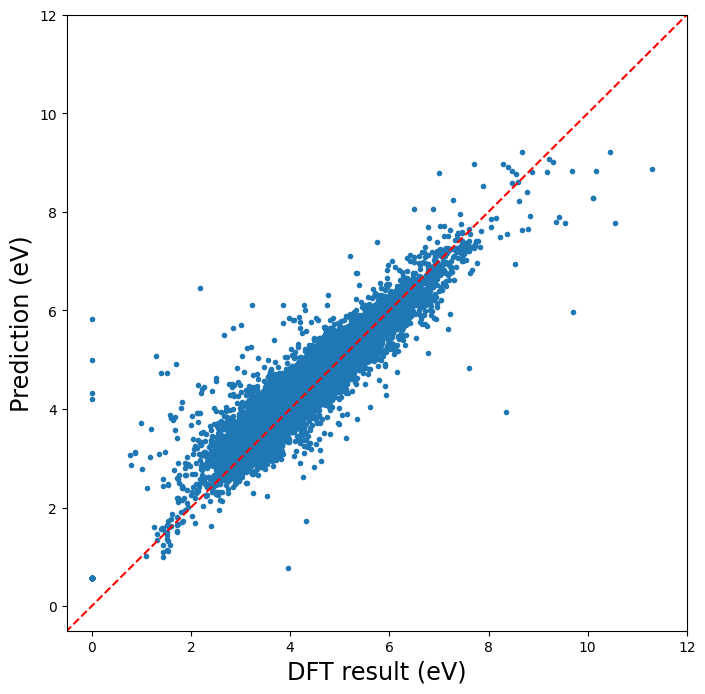

In [153]:
# parity plot
dft = [x for x in true_all]
prediction = [x for x in out_all]

plt.figure(figsize=(8, 8))
plt.scatter(dft, prediction, marker = '.')
plt.plot(range(-1, 16), range(-1, 16), 'r--')
plt.xlabel("DFT result (eV)", fontsize='xx-large')
plt.ylabel("Prediction (eV)", fontsize='xx-large')
plt.xlim(-0.5, 12)
plt.ylim(-0.5, 12);

In [154]:
corr = np.corrcoef(dft, prediction)
r = corr[0,1]
print(f"Pearson R: {r:.4f}")

Pearson R: 0.9352


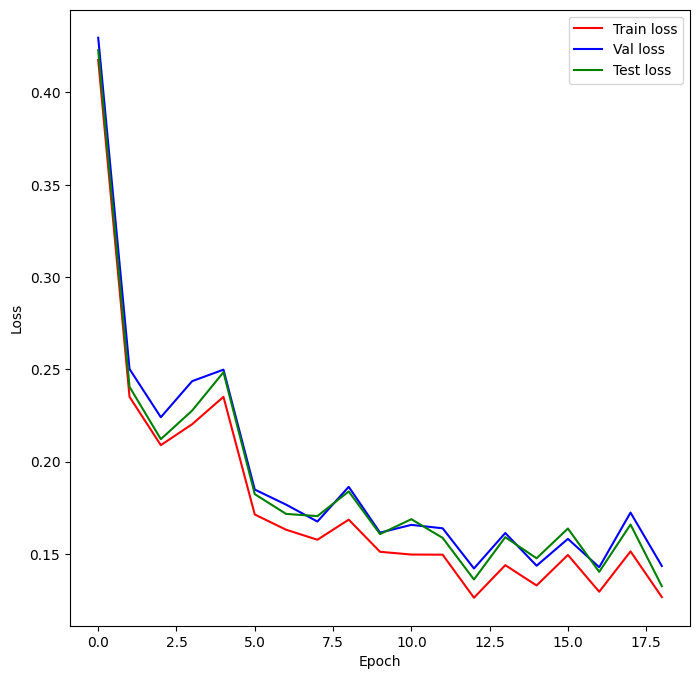

In [155]:
draw_loss_change(train_acc_list, val_acc_list, test_acc_list)

## GATv2Conv model (Using node features, edge indices, and edge attributes)

In [161]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, TransformerConv, GATv2Conv
from torch_geometric.nn import global_mean_pool

class myGATv2Conv(torch.nn.Module):
  def __init__(self, in_channel=35, hidden_layer_size=70):
    super().__init__()
    self.conv1 = GATv2Conv(in_channel, hidden_layer_size, edge_dim = 12)
    self.conv2 = GATv2Conv(hidden_layer_size, hidden_layer_size, edge_dim = 12)
    self.conv3 = GATv2Conv(hidden_layer_size, hidden_layer_size, edge_dim = 12)
    # self.conv4 = GCNConv(hidden_layer_size, hidden_layer_size)
    # self.conv5 = GCNConv(hidden_layer_size, hidden_layer_size)
    self.lin1 = Linear(hidden_layer_size, int(hidden_layer_size/2))
    self.lin2 = Linear(int(hidden_layer_size/2), 1)

  def forward(self, data):
    x, edge_index, batch, edge_attr, edge_weight = data.x, data.edge_index, data.batch, data.edge_attr, data.edge_weight

    x = self.conv1(x, edge_index, edge_attr)
    x = F.gelu(x)
    x = F.dropout(x, training=self.training)

    x = self.conv2(x, edge_index, edge_attr)
    x = F.gelu(x)

    x = self.conv3(x, edge_index, edge_attr)
    x = F.gelu(x)

    # x = self.conv4(x, edge_index)
    # x = F.elu(x)

    # x = self.conv5(x, edge_index)
    # x = F.elu(x)

    # READOUT
    x = global_mean_pool(x, batch)      # take the mean of node features, [batch_size, hidden_channels]
    x = self.lin1(x)
    x = F.elu(x)
    x = self.lin2(x)                    # final scalar

    return x

In [162]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

model = myGATv2Conv()
model.to(device)

cuda


myGATv2Conv(
  (conv1): GATv2Conv(35, 70, heads=1)
  (conv2): GATv2Conv(70, 70, heads=1)
  (conv3): GATv2Conv(70, 70, heads=1)
  (lin1): Linear(in_features=70, out_features=35, bias=True)
  (lin2): Linear(in_features=35, out_features=1, bias=True)
)

In [163]:
count_parameters(model)

+-----------------------+------------+
|        Modules        | Parameters |
+-----------------------+------------+
|       conv1.att       |     70     |
|       conv1.bias      |     70     |
|   conv1.lin_l.weight  |    2450    |
|    conv1.lin_l.bias   |     70     |
|   conv1.lin_r.weight  |    2450    |
|    conv1.lin_r.bias   |     70     |
| conv1.lin_edge.weight |    840     |
|       conv2.att       |     70     |
|       conv2.bias      |     70     |
|   conv2.lin_l.weight  |    4900    |
|    conv2.lin_l.bias   |     70     |
|   conv2.lin_r.weight  |    4900    |
|    conv2.lin_r.bias   |     70     |
| conv2.lin_edge.weight |    840     |
|       conv3.att       |     70     |
|       conv3.bias      |     70     |
|   conv3.lin_l.weight  |    4900    |
|    conv3.lin_l.bias   |     70     |
|   conv3.lin_r.weight  |    4900    |
|    conv3.lin_r.bias   |     70     |
| conv3.lin_edge.weight |    840     |
|      lin1.weight      |    2450    |
|       lin1.bias       |

30381

In [164]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()

In [165]:
train_acc_list = []
test_acc_list = []
val_acc_list = []

for epoch in range(1, 20):
    print("="*100)
    print("Epoch: ", epoch)
    train(train_loader)

    train_acc, out_tmp, true_tmp = test(train_loader)
    train_acc_list.append(train_acc)

    test_acc, out_all, true_all = test(test_loader)
    test_acc_list.append(test_acc)

    val_acc, val_pred, val_true = test(val_loader)
    val_acc_list.append(val_acc)

    print("-"*100)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch:  1
IDX:     0	Loss: 23.4277
IDX:   100	Loss: 0.5498
IDX:   200	Loss: 0.9403
IDX:   300	Loss: 0.5194
IDX:   400	Loss: 0.3961
IDX:   500	Loss: 0.2949
IDX:   600	Loss: 0.3708
IDX:   700	Loss: 0.3548
----------------------------------------------------------------------------------------------------
Epoch: 001, Train Acc: 0.4496, Val Acc: 0.4588, Test Acc: 0.4614
Epoch:  2
IDX:     0	Loss: 0.2407
IDX:   100	Loss: 0.3850
IDX:   200	Loss: 0.3917
IDX:   300	Loss: 0.2924
IDX:   400	Loss: 0.2276
IDX:   500	Loss: 0.3104
IDX:   600	Loss: 0.2554
IDX:   700	Loss: 0.3765
----------------------------------------------------------------------------------------------------
Epoch: 002, Train Acc: 0.2230, Val Acc: 0.2363, Test Acc: 0.2293
Epoch:  3
IDX:     0	Loss: 0.1986
IDX:   100	Loss: 0.1988
IDX:   200	Loss: 0.1567
IDX:   300	Loss: 0.1729
IDX:   400	Loss: 0.1202
IDX:   500	Loss: 0.1678
IDX:   600	Loss: 0.2106
IDX:   700	Loss: 0.3813
-------------------------------------------------------------

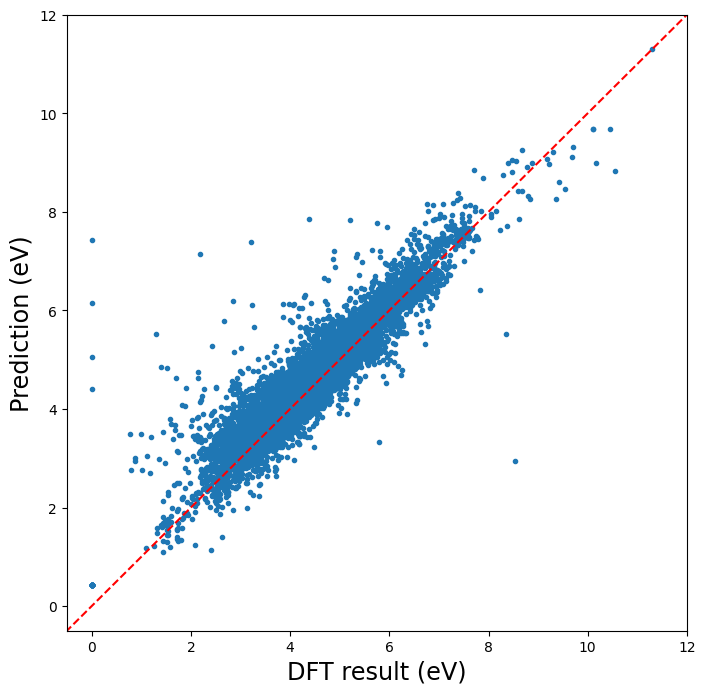

In [166]:
# parity plot
dft = [x for x in true_all]
prediction = [x for x in out_all]

plt.figure(figsize=(8, 8))
plt.scatter(dft, prediction, marker = '.')
plt.plot(range(-1, 16), range(-1, 16), 'r--')
plt.xlabel("DFT result (eV)", fontsize='xx-large')
plt.ylabel("Prediction (eV)", fontsize='xx-large')
plt.xlim(-0.5, 12)
plt.ylim(-0.5, 12);

In [167]:
corr = np.corrcoef(dft, prediction)
r = corr[0,1]
print(f"Pearson R: {r:.4f}")

Pearson R: 0.9308


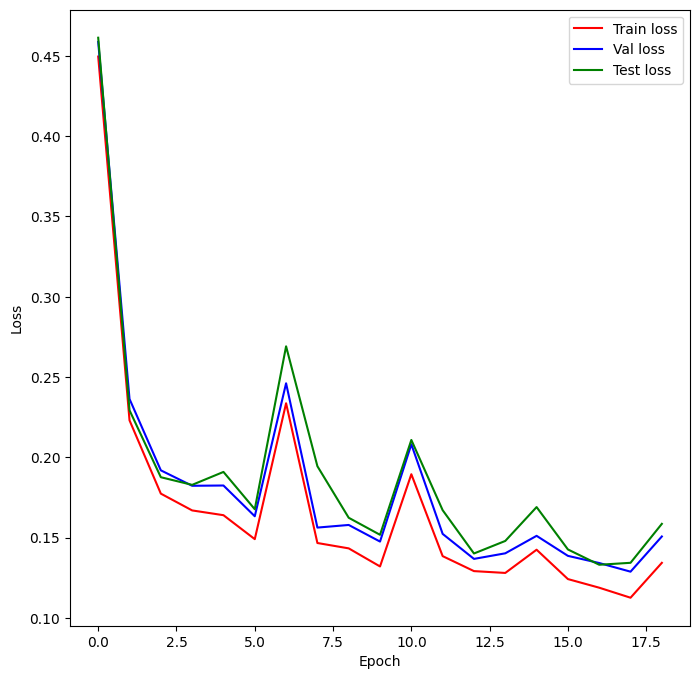

In [168]:
draw_loss_change(train_acc_list, val_acc_list, test_acc_list)